In [ ]:
#from dataset import Dataset
import time
from keras.datasets import cifar10
import numpy as np
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import seaborn as sns
import random
import sys

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
from torch.nn.modules.loss import CrossEntropyLoss

import torchvision.datasets as datasets

import copy
from copy import deepcopy
import random
import time

import json
import os
from PIL import Image
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATASET = 'CIFAR10'      # Choose between 'CIFAR2', 'CIFAR10'
MODEL = 'RESNET18'       # Choose between 'RESNET18', 'VGG11'
AUGMENTS = True          # Use Data Augmentation
SAVEMODEL = True         # Save Clean Model
LOADMODEL = False        # Load Clean Model

In [ ]:
# Set seed here for target / poisons / camous selection

seed = 200000111
np.random.seed(seed)
torch.manual_seed(seed+1)
torch.cuda.manual_seed(seed + 2)

#seed = 10540012



Prepare Datasets

In [ ]:
# Class Dictionary for CIFAR10
classDict = {'plane': 0, 'car': 1, 'bird': 2, 'cat': 3, 'deer': 4,
             'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

binaryClasses = {0:'Machine', 1:'Animal'} # Machine , Animal

In [ ]:
if DATASET == 'CIFAR2' or DATASET == 'CIFAR10':
  # Mean and std of CIFAR10:
  data_mean = (0.4914, 0.4822, 0.4465)
  data_std = (0.2470, 0.2435, 0.2616)
else:
  # Mean and std of Imagenet:
  data_mean = (0.485, 0.456, 0.406)
  data_std = (0.229, 0.224, 0.225)


In [ ]:
from torch.nn.modules.transformer import TransformerDecoderLayer
# Overwrite getitem method to obtain the index of the images when iterating through the images


from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader


class CIFAR10(Dataset):
    def __init__(self, train, transform):
        self.cifar10 = torchvision.datasets.CIFAR10(
                        root='./data', train=train, download=True, transform=transform)
        self.targets = self.cifar10.targets
        self.classes = self.cifar10.classes
        self.data = self.cifar10.data


    # Overloaded the getitem method to return index as well
    def __getitem__(self, index):
        data, target = self.cifar10[index]
        return data, target, index

    # Method to get all images' indices from a certain class without iterating through the loader
    def get_index(self, target_label):
      index_list = []
      for index, label in enumerate(self.targets):
        if label == target_label:
          index_list.append(index)
      return index_list

    def __len__(self):
        return len(self.cifar10)

    def remove(self, remove_list):
      mask = np.ones(len(self.cifar10), dtype=bool)
      mask[remove_list] = False
      data = self.data[mask]


In [ ]:
# Data Prep.

inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(data_mean, data_std)],
   std= [1/s for s in data_std]
)

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(data_mean, data_std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(data_mean, data_std),
])

if DATASET == 'CIFAR2' or DATASET == 'CIFAR10':
  trainset = CIFAR10(train=True, transform=transform_train)
  testset = CIFAR10(train=False, transform=transform_test)

# Binary Classfication

NUM_CLASS = 10

100%|██████████| 170498071/170498071 [00:13<00:00, 13045159.65it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:


#train_indices = np.random.choice(len(trainset), 5000)
#tets_indices = np.random.choice(len(testset), 1000)

#trainset = torch.utils.data.Subset(trainset, train_indices)
#testset = torch.utils.data.Subset(testset, tets_indices)



In [ ]:

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=100, shuffle=True)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False)


Initialize Models

In [ ]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()

        self.features = features

        self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        #return 2 * x - 1
        return x


In [ ]:
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],

def get_vgg_layers(config, batch_norm):

    layers = []
    in_channels = 3

    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size=2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = c

    return nn.Sequential(*layers)

In [ ]:
# Models: AlexNet - Not used

class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.5) -> None:
        super().__init__()
        #_log_api_usage_once(self)
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x



In [ ]:
class ResNet(torchvision.models.ResNet):
    """ResNet generalization for CIFAR-like thingies.

    This is a minor modification of
    https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py,
    adding additional options.
    """

    def __init__(self, block, layers, num_classes=2, zero_init_residual=False,
                 groups=1, base_width=64, replace_stride_with_dilation=[False, False, False, False],
                 norm_layer=torch.nn.BatchNorm2d, strides=[1, 2, 2, 2], initial_conv=[3, 1, 1]):
        """Initialize as usual. Layers and strides are scriptable."""
        super(torchvision.models.ResNet, self).__init__()  # torch.nn.Module
        self._norm_layer = norm_layer

        self.dilation = 1
        if len(replace_stride_with_dilation) != 4:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 4-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups

        self.inplanes = base_width
        self.base_width = 64  # Do this to circumvent BasicBlock errors. The value is not actually used.
        self.conv1 = torch.nn.Conv2d(3, self.inplanes, kernel_size=initial_conv[0],
                                     stride=initial_conv[1], padding=initial_conv[2], bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = torch.nn.ReLU(inplace=True)

        layer_list = []
        width = self.inplanes
        for idx, layer in enumerate(layers):
            layer_list.append(self._make_layer(block, width, layer, stride=strides[idx], dilate=replace_stride_with_dilation[idx]))
            width *= 2
        self.layers = torch.nn.Sequential(*layer_list)

        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.fc = torch.nn.Linear(width // 2 * block.expansion, num_classes)
        #self.predict = nn.Sigmoid()

        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (torch.nn.BatchNorm2d, torch.nn.GroupNorm)):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the arch by 0.2~0.3% according to https://arxiv.org/abs/1706.02677



    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layers(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        #x = self.predict(x)
        return x


In [ ]:
# Select model
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm=True)
initial_conv = [3, 1, 1]

if MODEL == 'VGG11':
  model = VGG(vgg11_layers, output_dim=NUM_CLASS)
elif MODEL == 'RESNET18':
  model = ResNet(torchvision.models.resnet.BasicBlock, [2, 2, 2, 2], num_classes=NUM_CLASS, base_width=64, initial_conv=initial_conv)
elif MODEL == "ALEXNET":
  model = AlexNet(num_classes = NUM_CLASS)

Losses and parameters for Fitting

In [ ]:
# Randomly select poison and target class:
# Assume Camouflage chosen from the same class as target.

avail_classes = np.arange(NUM_CLASS)
[target_class, poison_class] = np.random.choice(avail_classes, replace=False, size=2)
camou_class = target_class

print(target_class)
print(poison_class)


9
1


In [ ]:
# Setting up training params

epochs = 41
eta = 0.01
optimizer = torch.optim.SGD(params = model.parameters(), lr = eta, weight_decay = 5e-4, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
device = torch.device('cpu')
if DATASET == 'CIFAR2':
  loss_fun = nn.BCEWithLogitsLoss()
else:
  loss_fun = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Running on a GPU")
else:
    print("Running on a CPU...Uhh, are you sure you want to do this?")


Running on a GPU


In [ ]:
model.to(device)
model.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layers): Sequential(
    (0): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3,

Target image is chosen with ID [9174]


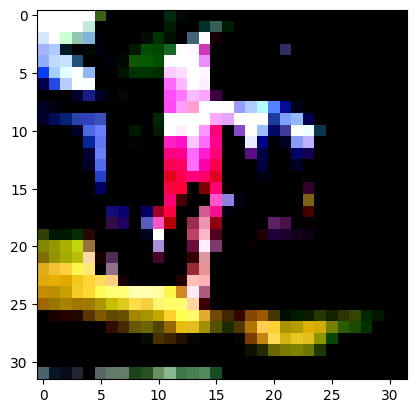

In [ ]:
# Get loss of each in the loader and choose Target

poison_index = trainset.get_index(poison_class)
target_index = testset.get_index(target_class)
camou_index = trainset.get_index(camou_class)

# Choose Target
target_index = [np.random.choice(target_index)]


targetset = data.Subset(testset, target_index)
targetloader = torch.utils.data.DataLoader(targetset)

print("Target image is chosen with ID {}".format(target_index))
plt.imshow(testset[target_index[0]][0].permute(1, 2, 0))

In [ ]:
# Optional Augmentation defenses

aug_transform1 = transforms.Compose([
transforms.RandomHorizontalFlip(p=0.5),
transforms.RandomRotation(degrees=5)
])

aug_transform = transforms.Compose([
transforms.RandomHorizontalFlip(p=0.5)
])

Fit


In [ ]:
start_time = time.time()


if not LOADMODEL:
  for epoch in range(epochs):
    train_loss = []

    correct_preds = 0
    total_preds = 0
    model.train()
    for inputs, labels, index in trainloader:

      inputs, labels = inputs.to(device), labels.to(device)
      if AUGMENTS:
        inputs = aug_transform(inputs)

      optimizer.zero_grad()            # reset the gradients to zero
      output = model(inputs)            # Generate model outputs

      if DATASET == 'CIFAR2':
        labels = labels.to(torch.float32)
        output = output.flatten()
      loss = loss_fun(output, labels)   # Calculate loss

      loss.backward()            # Compute gradients
      optimizer.step()            # update parameters,


      #For BCELoss:
      if DATASET == 'CIFAR2':
        predictions = torch.where(output < 0, 0, 1)
      else:
        predictions = torch.argmax(output.data, dim=1)

      total_preds += labels.size(0)
      correct_preds += (predictions == labels).sum().item()

      train_loss.append(loss.item())

    print("Training Epoch {}: Loss: {}, Accuracy: {}".format(epoch, np.mean(train_loss), correct_preds / total_preds))
    # validation phase - once every 10 epochs

    if epoch % 10 == 0:
      valid_losses = []
      correct = 0
      total = 0
      model.eval()

      # Evaluate Model
      for inputs, labels, index in testloader:
        inputs, labels = inputs.to(device), labels.to(device)


        with torch.no_grad():
          output = model(inputs)
          if DATASET == 'CIFAR2':
            labels = labels.to(torch.float32)
            output = output.flatten()

          # negative labels: when using hinge embedding loss only
          flipped_labels = labels # * -1
          loss = loss_fun(output, flipped_labels)   # Calculate loss

          valid_loss = loss_fun(output, labels)
          valid_losses.append(valid_loss.item())

          #predictions = torch.argmax(output, dim=1)
          if DATASET == 'CIFAR2':
            predictions = torch.where(output < 0, 0, 1)
          else:
            predictions = torch.argmax(output.data, dim=1)
          total += labels.size(0)
          correct += (predictions == labels).sum().item()

      # Evaluate Model on Target
      for inputs, labels, index in targetloader:
        #
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.no_grad():
          output = model(inputs)
          if DATASET == 'CIFAR2':
            labels = labels.to(torch.float32)
            output = output.flatten()
          #predictions = torch.argmax(output.data, dim=1)
          target_loss = loss_fun(output, labels)
          if DATASET == 'CIFAR2':
            predictions = torch.where(output < 0, 0, 1)
          else:
            predictions = torch.argmax(output.data, dim=1)
          print("Target Original Loss: {}".format(target_loss))

      print("Validation Epoch {}: Valid loss: {}, Accuracy: {}".format(epoch, np.mean(valid_losses), correct / total))
    scheduler.step()

  #   torch.autograd(model, target)
print("--- %s seconds ---" % (time.time() - start_time))

Training Epoch 0: Loss: 1.424996894955635, Accuracy: 0.47518
Target Original Loss: 1.355635643005371
Validation Epoch 0: Valid loss: 1.304959169626236, Accuracy: 0.5641
Training Epoch 1: Loss: 0.8870864392518997, Accuracy: 0.68524
Training Epoch 2: Loss: 0.6426850647330284, Accuracy: 0.77302
Training Epoch 3: Loss: 0.49668952748179435, Accuracy: 0.82734
Training Epoch 4: Loss: 0.38323745235800744, Accuracy: 0.8698
Training Epoch 5: Loss: 0.28629437056183815, Accuracy: 0.90448
Training Epoch 6: Loss: 0.20621965748071672, Accuracy: 0.93388
Training Epoch 7: Loss: 0.1408241024762392, Accuracy: 0.95648
Training Epoch 8: Loss: 0.09156524999812245, Accuracy: 0.97588
Training Epoch 9: Loss: 0.06098866893909872, Accuracy: 0.98664
Training Epoch 10: Loss: 0.04262538858316839, Accuracy: 0.99208
Target Original Loss: 0.10766652971506119
Validation Epoch 10: Valid loss: 0.6091720753908157, Accuracy: 0.8268
Training Epoch 11: Loss: 0.03193449473381042, Accuracy: 0.99524
Training Epoch 12: Loss: 0.0

In [ ]:
# Saving Clean Model

import os
PATH = "./drive/MyDrive/Poisoning_Machine_Unlearning/model"
os.makedirs(PATH, exist_ok = True)
PATH += "/resnet_cifar.ptr"


In [ ]:
if LOADMODEL:
  model.load_state_dict(torch.load(PATH))
  model.to(device)

if SAVEMODEL:
  torch.save(model.state_dict(), PATH)

In [ ]:
# Creating a subset of all machine images:

#machine_index = []

#for index in range(len(testset)):
#  if testset.targets[index] == -1:
#    machine_index.append(index)

#print(machine_index)

# torch.util.data.Subset()
#machine_loader =


In [ ]:
# Inverse normalization

inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(data_mean, data_std)],
   std= [1/s for s in data_std]
)

torch.Size([3, 32, 32])


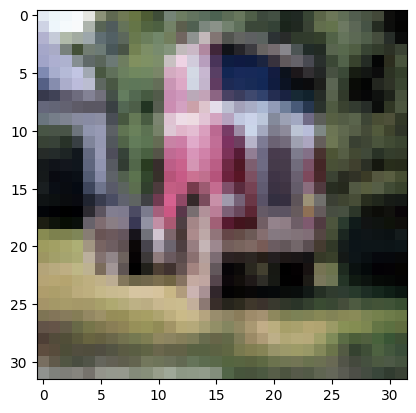

In [ ]:
# Show Target Image:
print(testset[target_index[0]][0].shape)
plt.imshow(inv_normalize(testset[target_index[0]][0]).permute(1, 2, 0))
target_image = data.Subset(testset, indices=target_index)
target_label = torch.Tensor([5]).to(device).long()


In [ ]:
# Poison parameters:
# theta = model.coef_
budget = 500 # number of poisoned images
camou_budget = 500
R = 4 # restarts
epsilon = 16 # perturbation bound
attackiter = 251 # optimization steps
loss_opt = sys.maxsize # optimal loss
delta_opt = 0 # optimal delta
poison_opt = [] # optimal poison images

In [ ]:
# Choose Poison Images:

poison_index = np.random.choice(poison_index, budget, replace=False)
poison_dict = {}

for index, val in enumerate(poison_index):
  poison_dict[val] = index



In [ ]:
poisonset = data.Subset(trainset, poison_index)
poisonloader = torch.utils.data.DataLoader(poisonset, batch_size=128, drop_last=False)

In [ ]:
# Initialize poison_delta

std_tensor = torch.tensor(data_std)[None, :, None, None]
mean_tensor = torch.tensor(data_mean)[None, :, None, None]

print(std_tensor)
print(mean_tensor)

model.eval()


tensor([[[[0.2470]],

         [[0.2435]],

         [[0.2616]]]])
tensor([[[[0.4914]],

         [[0.4822]],

         [[0.4465]]]])


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layers): Sequential(
    (0): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3,

In [ ]:
# Function to calculate gradient:

def gradient(model, images, labels, criterion=None):
    """Compute the gradient of criterion(model) w.r.t to given data."""

#    labels_uns = labels.unsqueeze(1)
#    labels_uns = labels_uns
    if DATASET == 'CIFAR2':
      loss = loss_fun(model(images).flatten(), labels.float())
    else:
      loss = loss_fun(model(images), labels)
    gradients = torch.autograd.grad(loss, model.parameters(), only_inputs=True)
    grad_norm = 0
    for grad in gradients:
        grad_norm += grad.detach().pow(2).sum()
    grad_norm = grad_norm.sqrt()
    return gradients, grad_norm

In [ ]:
# Calculate target gradient:

targets = torch.stack([data[0] for data in target_image], dim=0).to(device)
intended_classes = torch.tensor([poison_class]).to(device=device, dtype=torch.long)
true_classes = torch.tensor([data[1] for data in target_image]).to(device=device, dtype=torch.long)


print(true_classes)

target_grad, target_grad_norm = gradient(model, targets, intended_classes)

print(target_grad_norm)

tensor([9], device='cuda:0')
tensor(415.6664, device='cuda:0')


In [ ]:
# Similarity Loss calculation for poison

norm_type = 2
support_data = {}

def compute_loss(inputs, labels, support_data):
  target_losses = 0
  poison_norm = 0

  outputs = model(inputs)#.flatten()
  flipped_labels = labels#* -1

  if DATASET == 'CIFAR2':
    labels = labels.to(torch.float32)
    outputs = outputs.flatten()
    poison_prediction = torch.where(outputs < 0, 0, 1)
  else:
    poison_prediction = torch.argmax(outputs.data, dim=1)

  poison_correct = (poison_prediction == labels).sum().item()

  poison_loss = loss_fun(outputs, flipped_labels)
  poison_grad = torch.autograd.grad(poison_loss, model.parameters(), retain_graph=True, create_graph=True)

  indices = torch.arange(len(poison_grad))
  #print(indices)
  for i in indices:
    target_losses -= (poison_grad[i] * target_grad[i]).sum()
    poison_norm += poison_grad[i].pow(2).sum()

  poison_norm = poison_norm.sqrt()

  # poison_grad_norm = torch.norm(torch.stack([torch.norm(grad, norm_type).to(device) for grad in poison_grad]), norm_type)
  target_losses /= target_grad_norm

  target_losses = 1 + target_losses / poison_norm
  target_losses.backward()

  return target_losses.detach().cpu(), poison_correct


#compute_loss(support_data)

# Witches Brew

Trial #0:


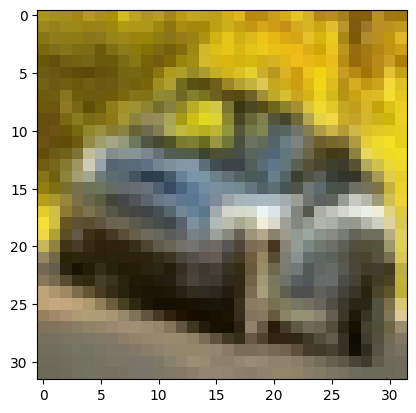

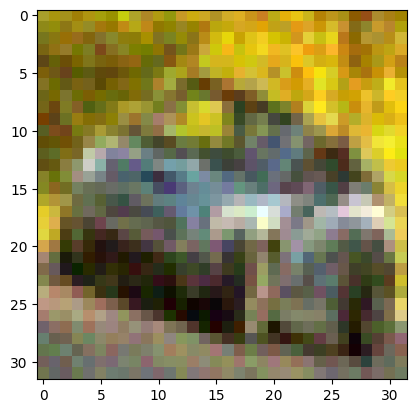

For iterations 0 Target-Poison Loss is 0.41437849402427673
For iterations 0 Poison accuracy is 0.962


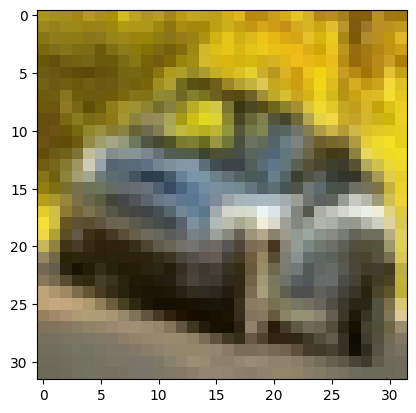

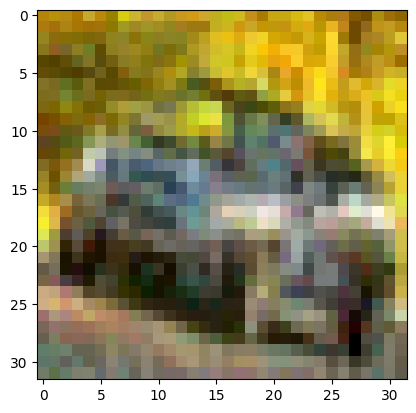

For iterations 50 Target-Poison Loss is 0.20508849620819092
For iterations 50 Poison accuracy is 0.446


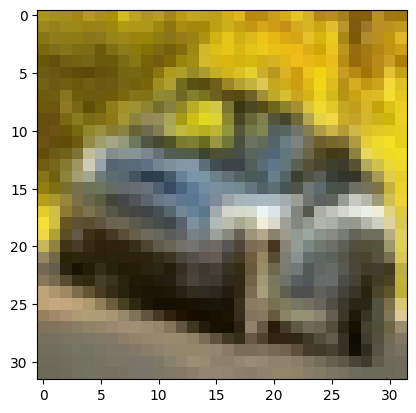

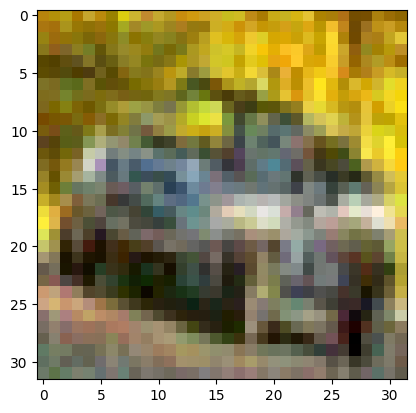

For iterations 100 Target-Poison Loss is 0.19291840493679047
For iterations 100 Poison accuracy is 0.55


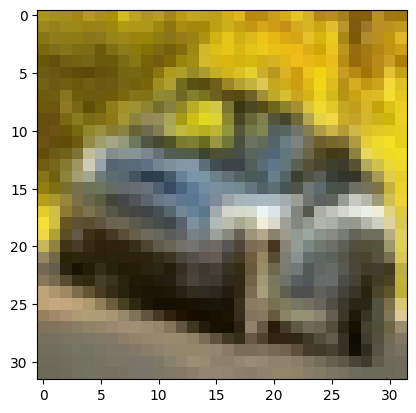

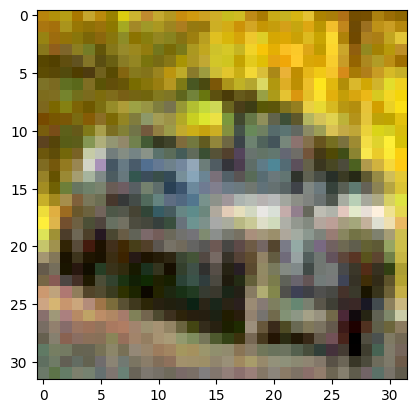

For iterations 150 Target-Poison Loss is 0.19064629077911377
For iterations 150 Poison accuracy is 0.628


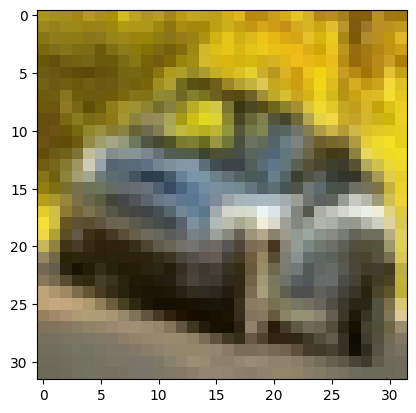

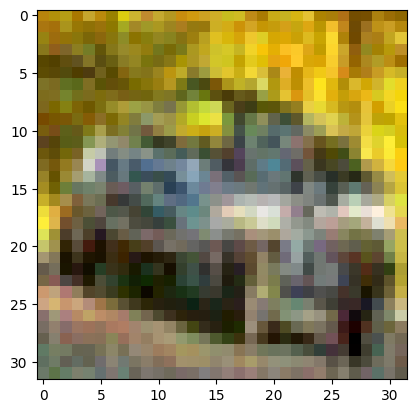

For iterations 200 Target-Poison Loss is 0.18953153491020203
For iterations 200 Poison accuracy is 0.678


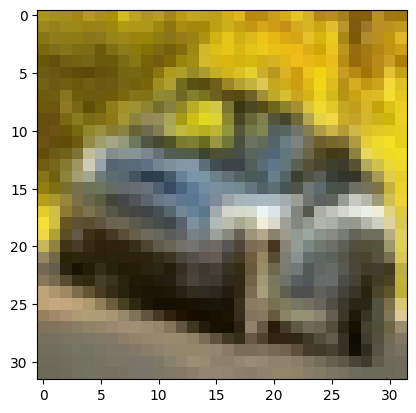

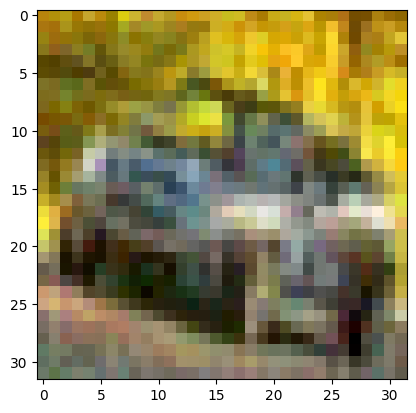

For iterations 250 Target-Poison Loss is 0.1896912008523941
For iterations 250 Poison accuracy is 0.71
Trial #1:


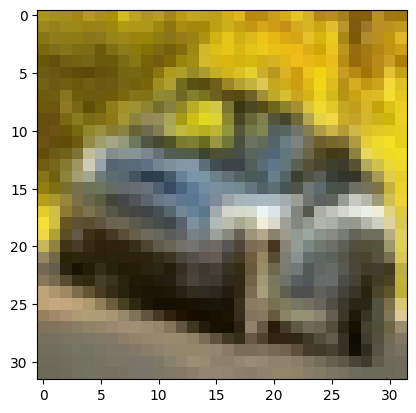

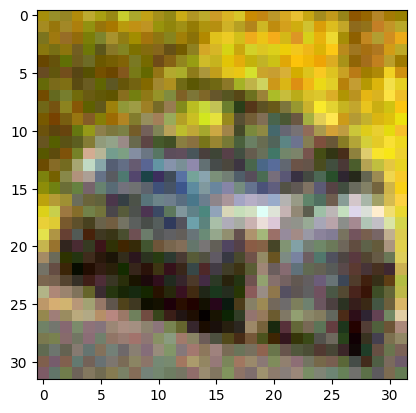

For iterations 0 Target-Poison Loss is 0.41303718090057373
For iterations 0 Poison accuracy is 0.956


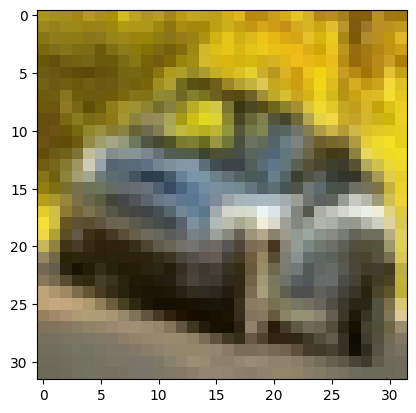

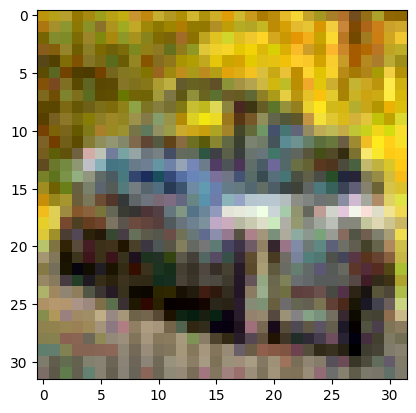

For iterations 50 Target-Poison Loss is 0.20477885007858276
For iterations 50 Poison accuracy is 0.428


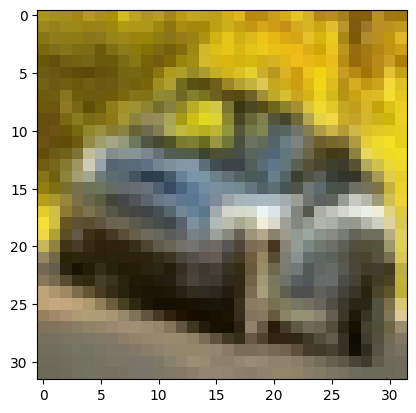

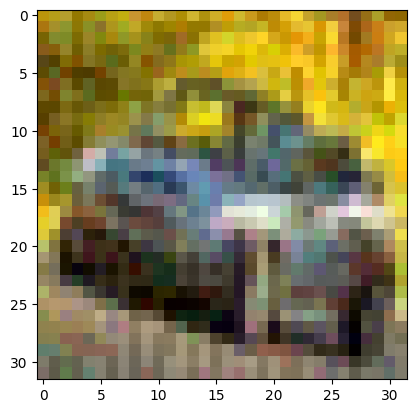

For iterations 100 Target-Poison Loss is 0.19393904507160187
For iterations 100 Poison accuracy is 0.534


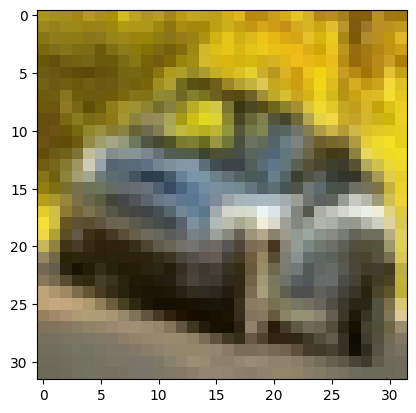

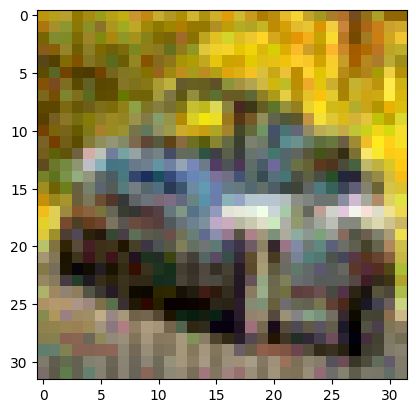

For iterations 150 Target-Poison Loss is 0.19234277307987213
For iterations 150 Poison accuracy is 0.616


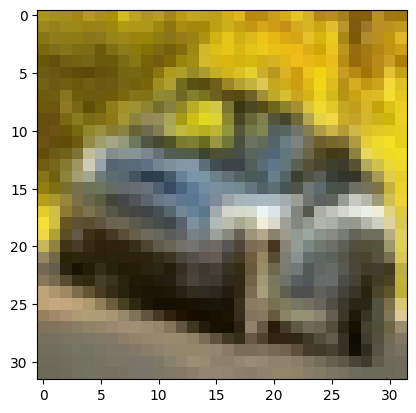

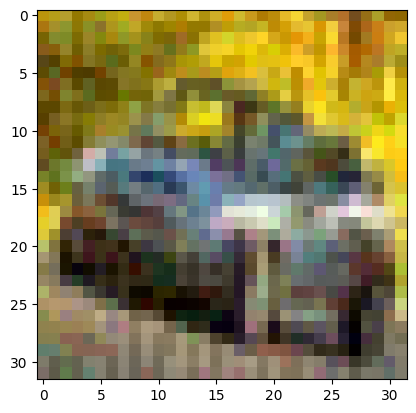

For iterations 200 Target-Poison Loss is 0.18951953947544098
For iterations 200 Poison accuracy is 0.668


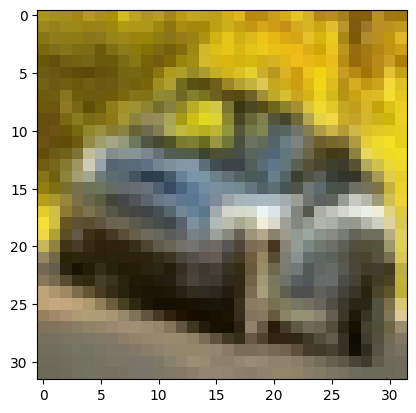

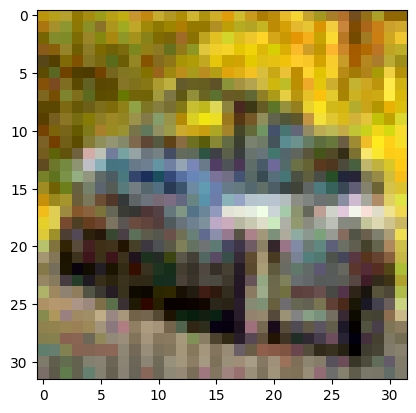

For iterations 250 Target-Poison Loss is 0.1909860223531723
For iterations 250 Poison accuracy is 0.706
Trial #2:


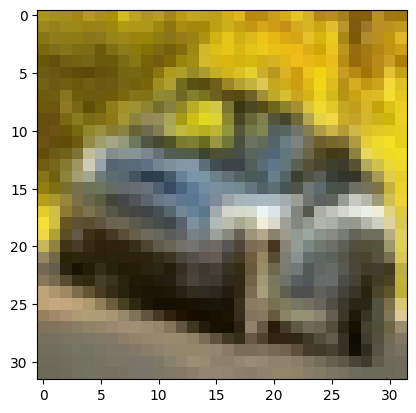

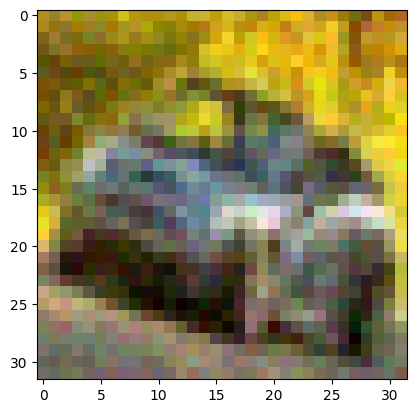

For iterations 0 Target-Poison Loss is 0.43366682529449463
For iterations 0 Poison accuracy is 0.952


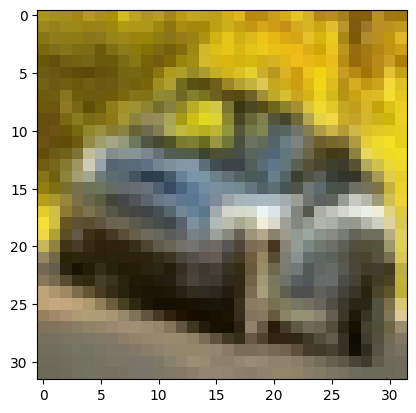

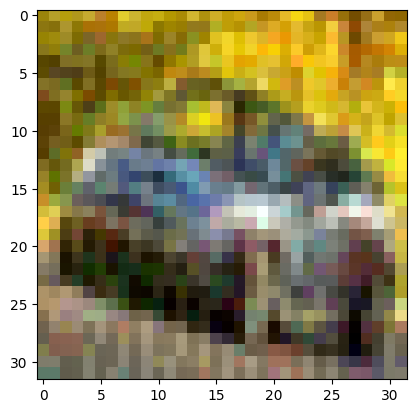

For iterations 50 Target-Poison Loss is 0.20707710087299347
For iterations 50 Poison accuracy is 0.404


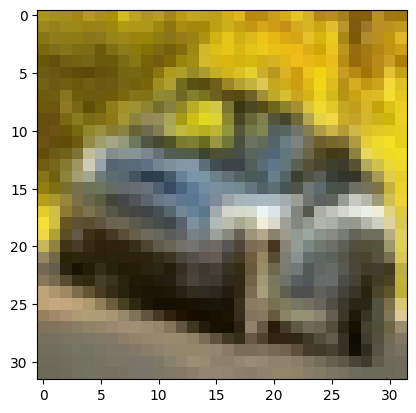

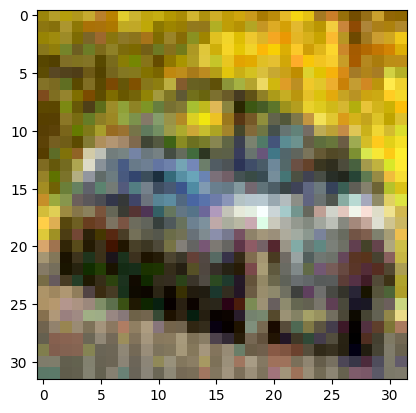

For iterations 100 Target-Poison Loss is 0.19508078694343567
For iterations 100 Poison accuracy is 0.518


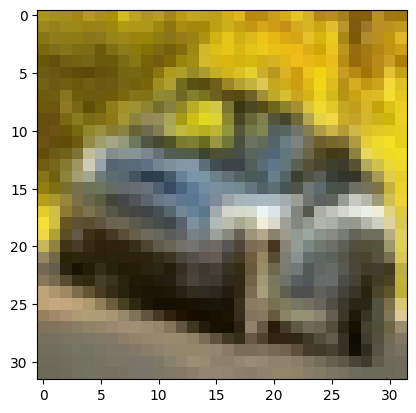

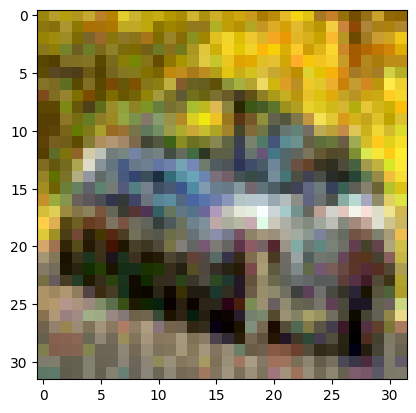

For iterations 150 Target-Poison Loss is 0.190174862742424
For iterations 150 Poison accuracy is 0.582


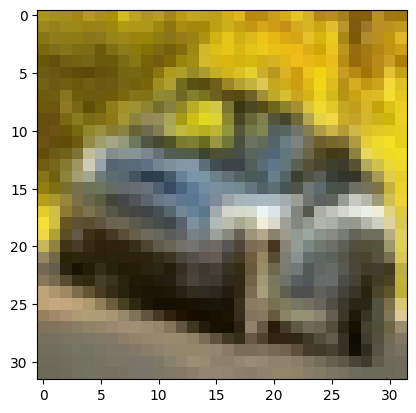

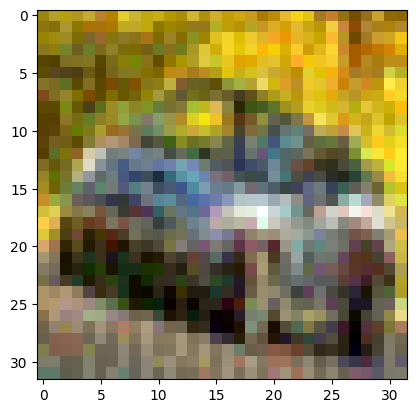

For iterations 200 Target-Poison Loss is 0.18824617564678192
For iterations 200 Poison accuracy is 0.634


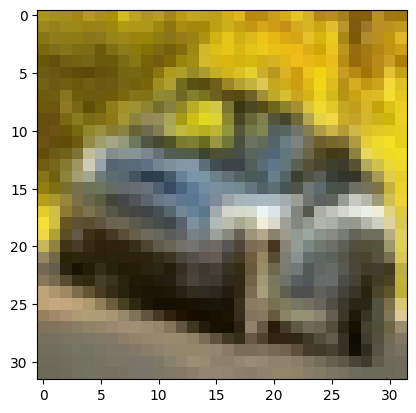

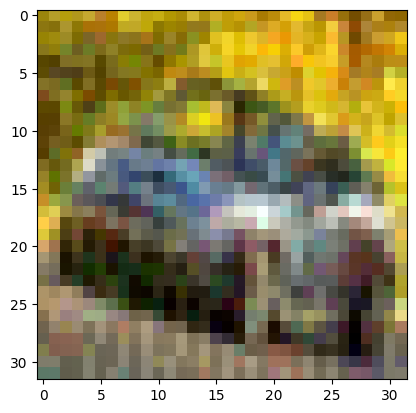

For iterations 250 Target-Poison Loss is 0.1889209896326065
For iterations 250 Poison accuracy is 0.674
Trial #3:


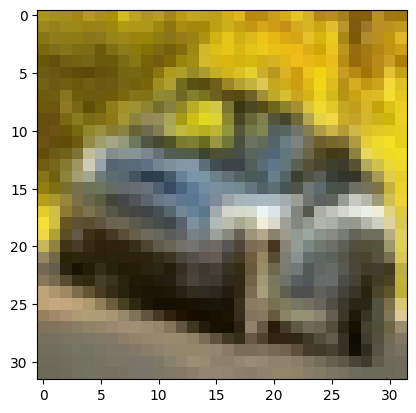

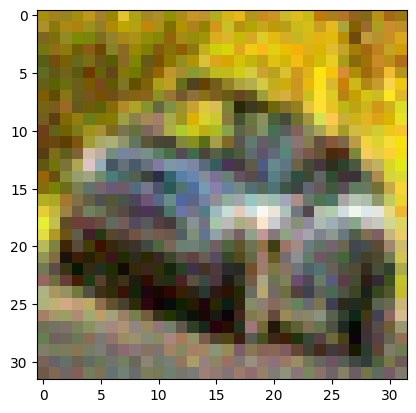

For iterations 0 Target-Poison Loss is 0.4210367798805237
For iterations 0 Poison accuracy is 0.964


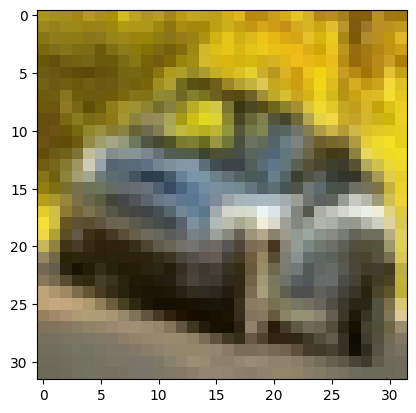

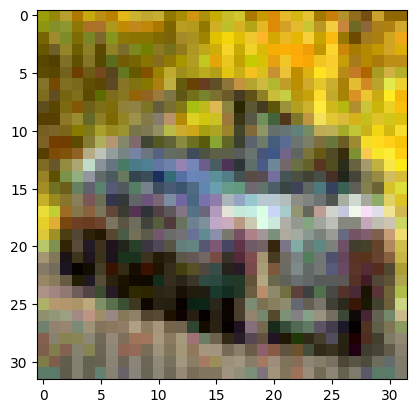

For iterations 50 Target-Poison Loss is 0.20705878734588623
For iterations 50 Poison accuracy is 0.442


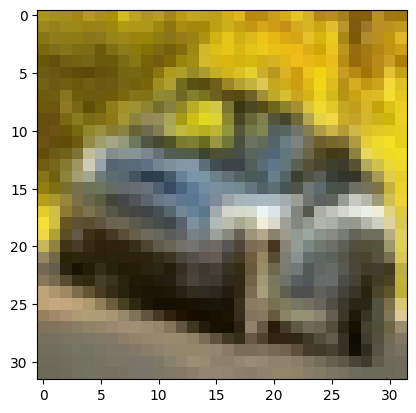

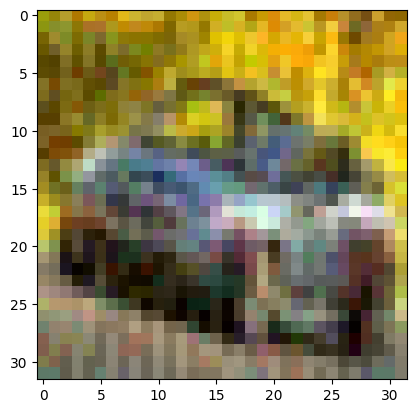

For iterations 100 Target-Poison Loss is 0.19478648900985718
For iterations 100 Poison accuracy is 0.53


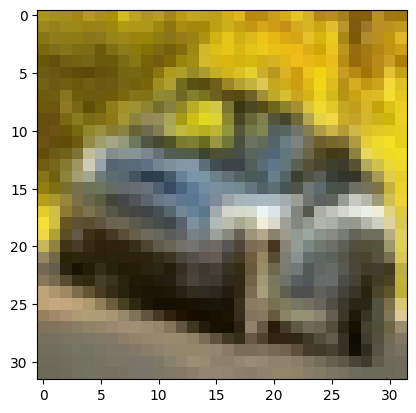

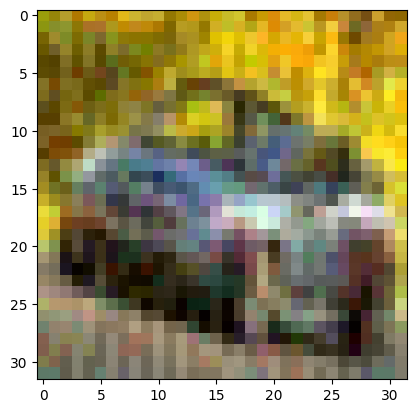

For iterations 150 Target-Poison Loss is 0.1904740333557129
For iterations 150 Poison accuracy is 0.604


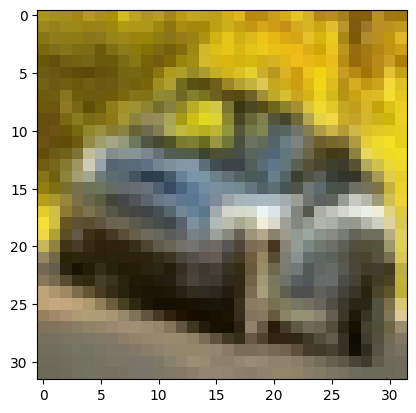

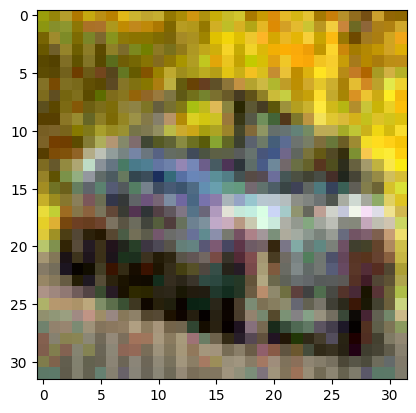

For iterations 200 Target-Poison Loss is 0.18869450688362122
For iterations 200 Poison accuracy is 0.646


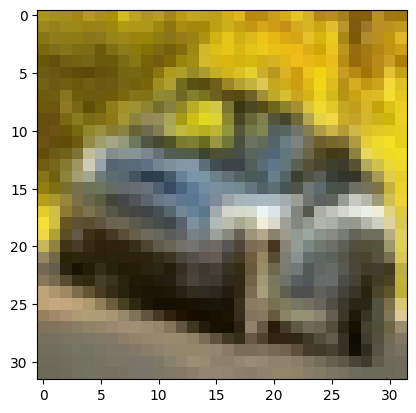

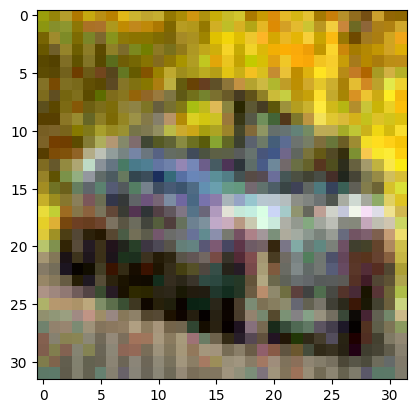

For iterations 250 Target-Poison Loss is 0.18678241968154907
For iterations 250 Poison accuracy is 0.688
Trial #0 selected with target loss 0.1896912008523941
--- 420.69867873191833 seconds ---


In [ ]:
# Brew Poisons
#1410 106
start_time = time.time()

poison_deltas = []
minimum_loss = 1
minimum_loss_trial = 0

for trial in range(R):
  init_lr = 0.1
  print("Trial #{}:".format(trial))

  poison_delta = torch.randn(len(poison_index), *trainset[0][0].shape)
  poison_delta *= epsilon / std_tensor / 255
  poison_delta.data = torch.max(torch.min(poison_delta, epsilon / (std_tensor * 255)), -epsilon / (std_tensor * 255))

  att_optimizer = torch.optim.Adam([poison_delta], lr=init_lr)

  poison_bounds = torch.zeros_like(poison_delta)
  for iter in range(attackiter):

      target_loss = 0
      poison_correct = 0

      poison_delta.grad = torch.zeros_like(poison_delta)
      poison_delta.requires_grad_()
      for batch, example in enumerate(poisonloader):

        inputs, labels, ids = example

        inputs = inputs.to(device)
        labels = labels.to(device)
        if iter % 50 == 0 and batch == 0:
          plt.imshow(inv_normalize(inputs[0]).permute(1, 2, 0).cpu().detach().numpy())
          plt.show()

        ### Add delta to the correct images

        poison_slices, batch_positions = [], []
        for batch_id, image_id in enumerate(ids.tolist()):
            lookup = poison_dict.get(image_id)
            if lookup is not None:
                poison_slices.append(lookup)
                batch_positions.append(batch_id)

        if len(batch_positions) > 0:
            delta_slice = poison_delta[poison_slices].detach().to(device)
            delta_slice.requires_grad_()
            poison_images = inputs[batch_positions]
            inputs[batch_positions] += delta_slice
        if iter % 50 == 0 and batch == 0:
          plt.imshow(inv_normalize(inputs[0]).permute(1, 2, 0).cpu().detach().numpy())
          plt.show()

###################################################################################
        loss, p_correct = compute_loss(inputs, labels, support_data)
###################################################################################

        # Update Step:
        poison_delta.grad[poison_slices] = delta_slice.grad.detach().to(device=torch.device('cpu'))
        poison_bounds[poison_slices] = poison_images.detach().to(device=torch.device('cpu'))
        #for i in range(budget):

        #  poison_bounds[i] = poison_delta[i]
        #print(poison_delta.grad)

        target_loss += loss
        poison_correct += p_correct

      if iter % 50 == 0:
        print("For iterations {} Target-Poison Loss is {}".format(iter, target_loss/(batch + 1)))
        print("For iterations {} Poison accuracy is {}".format(iter, poison_correct / budget))

      #poison_delta.grad.sign_()
      att_optimizer.step()
      att_optimizer.zero_grad()

      with torch.no_grad():
        #Projection Step

        poison_delta.data = torch.max(torch.min(poison_delta, epsilon / std_tensor / 255), -epsilon / std_tensor / 255)
        poison_delta.data = torch.max(torch.min(poison_delta, (1 - mean_tensor) / std_tensor - poison_bounds), -mean_tensor / std_tensor - poison_bounds)

  if iter == attackiter - 1:
    poison_deltas.append(poison_delta)
    if target_loss < minimum_loss:
      minimum_loss = target_loss/(batch + 1)
      minimum_loss_trial = trial

poison_delta = poison_deltas[minimum_loss_trial]

print("Trial #{} selected with target loss {}".format(minimum_loss_trial, minimum_loss))
print("--- %s seconds ---" % (time.time() - start_time))


In [ ]:
import os
PATH = "./drive/MyDrive/Poisoning_Machine_Unlearning/model"
os.makedirs(PATH, exist_ok = True)
PATH += "/poison_cifar_l2dcharts.npy"

#with open(PATH, 'wb') as f:
#  np.save(f, poison_delta.detach().numpy())

#with open(PATH, 'rb') as f:
#  poison_delta = np.load(f)
#poison_delta = torch.from_numpy(poison_delta)

In [ ]:
#Take a look at the Poison images

PATH = "./drive/MyDrive/Poisoning_Machine_Unlearning/poisons"
os.makedirs(PATH, exist_ok = True)


for batch, example in enumerate(poisonloader):
        inputs, labels, ids = example

        inputs = inputs.to(device)
        labels = labels.to(torch.float32).to(device)

        poison_order = []
        batch_ids = []

        # Use poison_dict to match poison_delta[i] to the correct poison image:
        for batch_id, image_id in enumerate(ids.tolist()):
            batch_ids.append(batch_id)
            poison_order.append(poison_dict[image_id])

        delta_slice = poison_delta[poison_order].detach().to(device)
        delta_slice.requires_grad_()
        #poison_images = inputs[batch_ids]

        #for input in inputs:
          #print("Original images:")
          #plt.imshow(inv_normalize(input).permute(1, 2, 0).cpu().detach().numpy())
          #plt.show()
        inputs[batch_ids] += delta_slice.to(device)
          #print("Poisoned Images:")
          #plt.imshow(inv_normalize(input).permute(1, 2, 0).cpu().detach().numpy())
        save_path = PATH + "/poison_batch_{}.npy".format(batch)
        np.save(save_path, inputs.cpu().detach().numpy())

          #plt.show()

        if batch == 10:
          break


In [ ]:
# Code to remove a portion of the poison images

'''
portion = 1.0 #Remaining portions

poison_index_chopped = np.random.choice(poison_index, math.floor(portion*budget), replace=False)
print(len(poison_index_chopped))
poison_dict_chopped = {}

for index, val in enumerate(poison_index_chopped):
  poison_dict_chopped[val] = poison_dict[val]

poison_dict = poison_dict_chopped
'''

'\nportion = 1.0 #Remaining portions\n\npoison_index_chopped = np.random.choice(poison_index, math.floor(portion*budget), replace=False)\nprint(len(poison_index_chopped))\npoison_dict_chopped = {}\n\nfor index, val in enumerate(poison_index_chopped):\n  poison_dict_chopped[val] = poison_dict[val]\n\npoison_dict = poison_dict_chopped\n'

In [ ]:
# Retraining 1:
if MODEL == 'VGG11':
  vgg11_layers = get_vgg_layers(vgg11_config, batch_norm=True)
  model2 = VGG(vgg11_layers, output_dim=10)
elif MODEL == 'RESNET18':
  model2 = ResNet(torchvision.models.resnet.BasicBlock, [2, 2, 2, 2], num_classes=NUM_CLASS, base_width=64, initial_conv=initial_conv)


#model2 = ResNet(torchvision.models.resnet.BasicBlock, [2, 2, 2, 2], num_classes=NUM_CLASS, base_width=64, initial_conv=initial_conv)
model2 = model2.to(device)
optimizer = torch.optim.SGD(params = model2.parameters(), lr = eta, weight_decay = 5e-4, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

optimizer.zero_grad()

for epoch in range(epochs):

  train_loss = []

  correct_preds = 0
  total_preds = 0
  for inputs, labels, index in trainloader:
    model2.train()
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()            # reset the gradients to zero
    picture_id = []
    poison_order = []

    # Use poison_dict to match poison_delta[i] to the correct poison image:
    for order, id in enumerate(index.tolist()):
      if poison_dict.get(id) is not None:
        picture_id.append(order)
        poison_order.append(poison_dict[id])
        #print("{} ({}) : {}".format(id, order, poison_dict[id])) # Check matching

    if len(poison_order) > 0:
      inputs[picture_id] += poison_delta[poison_order].to(device)

    if AUGMENTS:
      inputs = aug_transform(inputs)


    output = model2(inputs)            # Generate model outputs
    #labels = labels.to(torch.float32).unsqueeze(1)

    if DATASET == 'CIFAR2':
      labels = labels.to(torch.float32)
      output = output.flatten()

    loss = loss_fun(output, labels)   # Calculate loss

    loss.backward()            # Compute gradients
    optimizer.step()            # update parameters,

    if DATASET == 'CIFAR2':
      predictions = torch.where(output < 0, 0, 1)
    else:
      predictions = torch.argmax(output.data, dim=1)

    total_preds += labels.size(0)
    correct_preds += (predictions == labels).sum().item()

    train_loss.append(loss.item())

  print("Training Epoch {}: Loss: {}, Accuracy: {}".format(epoch, np.mean(train_loss), correct_preds / total_preds))
  # validation phase - once every 10 epochs

  if epoch % 10 == 0:
    model2.eval()
    valid_losses = []
    correct = 0
    total = 0

    for inputs, labels, index in targetloader:
      inputs, labels = inputs.to(device), labels.to(device)
      with torch.no_grad():
        output = model2(inputs)
        if DATASET == 'CIFAR2':
          labels = labels.to(torch.float32)
          output = output.flatten()
        if DATASET == 'CIFAR2':
          predictions = torch.where(output < 0, 0, 1)
        else:
          predictions = torch.argmax(output.data, dim=1)
        print(output)

      if predictions[0] != intended_classes[0]:
        print("Target is not fooled.")
      else:
        print("Target is fooled.")

    for inputs, labels, index in testloader:
      #
      inputs, labels = inputs.to(device), labels.to(device)
      with torch.no_grad():
        output = model2(inputs)
        if DATASET == 'CIFAR2':
          labels = labels.to(torch.float32)
          output = output.flatten()

        valid_loss = loss_fun(output, labels) # Calculate loss
        valid_losses.append(valid_loss.item())

        if DATASET == 'CIFAR2':
          predictions = torch.where(output < 0, 0, 1)
        else:
          predictions = torch.argmax(output.data, dim=1)
        total += labels.size(0)
        correct += (predictions == labels).sum().item()

    print("Validation Epoch {}: Valid loss: {}, Accuracy: {}".format(epoch, np.mean(valid_losses), correct / total))
  scheduler.step()

Training Epoch 0: Loss: 1.4423090130090714, Accuracy: 0.4716
tensor([[-0.3460,  0.6716, -1.6717, -0.2032, -0.4730, -0.2631, -1.7659,  1.8195,
         -0.9219,  4.2519]], device='cuda:0')
Target is not fooled.
Validation Epoch 0: Valid loss: 1.0711984372138976, Accuracy: 0.6153
Training Epoch 1: Loss: 0.9061069144010544, Accuracy: 0.67546
Training Epoch 2: Loss: 0.6673279272913932, Accuracy: 0.7651
Training Epoch 3: Loss: 0.5135625820159913, Accuracy: 0.82084
Training Epoch 4: Loss: 0.38976844570040703, Accuracy: 0.86674
Training Epoch 5: Loss: 0.29125869722664355, Accuracy: 0.90434
Training Epoch 6: Loss: 0.2079017661511898, Accuracy: 0.93486
Training Epoch 7: Loss: 0.13970761249959468, Accuracy: 0.95948
Training Epoch 8: Loss: 0.09708855705708265, Accuracy: 0.97548
Training Epoch 9: Loss: 0.061118267353624106, Accuracy: 0.98622
Training Epoch 10: Loss: 0.04043981385976076, Accuracy: 0.99352
tensor([[-5.4177,  8.8550, -0.6567,  1.2824, -0.2687, -0.7792, -0.9799, -5.3503,
         -0.5

In [ ]:
import os
PATH = "./drive/MyDrive/Poisoning_Machine_Unlearning/model"
os.makedirs(PATH, exist_ok = True)
PATH += "/resnet_cifar_poisoned.ptr"
torch.save(model2.state_dict(), PATH)

# Camouflage Code


In [ ]:
# Camou set:

camou_index = np.random.choice(camou_index, camou_budget, replace=False)
camou_dict = {}

for index, val in enumerate(camou_index):
  camou_dict[val] = index

camouset = data.Subset(trainset, camou_index)


In [ ]:
print(len(trainset))
camouloader = DataLoader(camouset, batch_size=128, drop_last=False)
combinedloader = DataLoader(trainset,shuffle=True,batch_size=100)

50000


In [ ]:
target_grad, target_grad_norm = gradient(model, targets, true_classes)

print(target_grad_norm)



tensor(0.4772, device='cuda:0')


Trial #0:


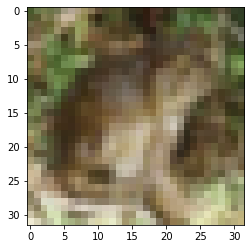

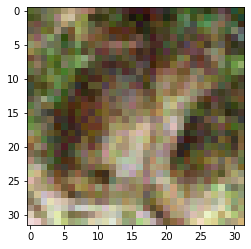

For iterations 0 Target-Camou Loss is 0.5591648817062378
For iterations 0 Camou accuracy is 0.996


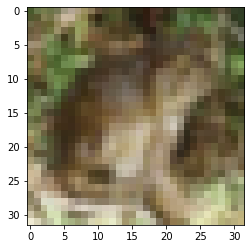

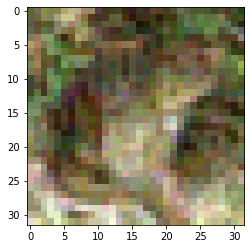

For iterations 50 Target-Camou Loss is 0.22208194434642792
For iterations 50 Camou accuracy is 0.586


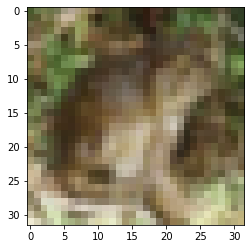

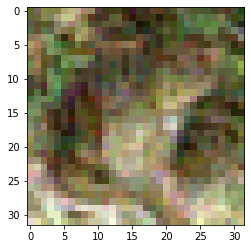

For iterations 100 Target-Camou Loss is 0.19177716970443726
For iterations 100 Camou accuracy is 0.738


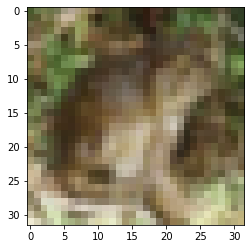

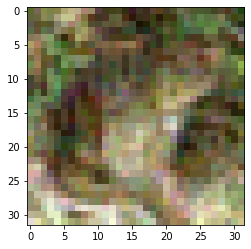

For iterations 150 Target-Camou Loss is 0.18941281735897064
For iterations 150 Camou accuracy is 0.832


KeyboardInterrupt: ignored

In [ ]:
# Brew Camou Images:
start_time = time.time()

camou_deltas = []
minimum_loss = 1
minimum_loss_trial = 0

for trial in range(R):
  init_lr = 0.1
  if trial > -(R // -2):
    init_lr = 0.01

  print("Trial #{}:".format(trial))

  camou_delta = torch.randn(len(camou_index), *trainset[0][0].shape)
  camou_delta *= epsilon / std_tensor / 255
  camou_delta.data = torch.max(torch.min(camou_delta, epsilon / (std_tensor * 255)), -epsilon / (std_tensor * 255))

  att_optimizer = torch.optim.Adam([camou_delta], lr=init_lr)

  camou_delta.grad = torch.zeros_like(camou_delta)
  camou_delta.requires_grad_()

  camou_bounds = torch.zeros_like(camou_delta)
  for iter in range(attackiter):

      target_loss = 0
      camou_correct = 0
      for batch, example in enumerate(camouloader):

        inputs, labels, ids = example

        inputs = inputs.to(device)
        labels = labels.to(device)

        if DATASET == 'CIFAR2':
          labels = labels.to(torch.float32)

        if iter % 50 == 0 and batch == 0:
          plt.imshow(inv_normalize(inputs[0]).permute(1, 2, 0).cpu().detach().numpy())
          plt.show()

        ### Add delta to the correct images

        camou_slices, batch_positions = [], []
        for batch_id, image_id in enumerate(ids.tolist()):
            lookup = camou_dict.get(image_id)
            if lookup is not None:
                camou_slices.append(lookup)
                batch_positions.append(batch_id)

        if len(batch_positions) > 0:
            delta_slice = camou_delta[camou_slices].detach().to(device)
            delta_slice.requires_grad_()
            camou_images = inputs[batch_positions]
            inputs[batch_positions] += delta_slice
        if iter % 50 == 0 and batch == 0:
          plt.imshow(inv_normalize(inputs[0]).permute(1, 2, 0).cpu().detach().numpy())
          plt.show()

###################################################################################
        loss, p_correct = compute_loss(inputs, labels, support_data)
###################################################################################

        # Update Step:
        camou_delta.grad[camou_slices] = delta_slice.grad.detach().to(device=torch.device('cpu'))
        camou_bounds[camou_slices] = camou_images.detach().to(device=torch.device('cpu'))


        target_loss += loss
        camou_correct += p_correct

      if iter % 50 == 0:
        print("For iterations {} Target-Camou Loss is {}".format(iter, target_loss/(batch + 1)))
        print("For iterations {} Camou accuracy is {}".format(iter, camou_correct / budget))

      att_optimizer.step()
      att_optimizer.zero_grad()

      with torch.no_grad():
        camou_delta.data = torch.max(torch.min(camou_delta, epsilon / std_tensor / 255), -epsilon / std_tensor / 255)
        camou_delta.data = torch.max(torch.min(camou_delta, (1 - mean_tensor) / std_tensor - camou_bounds), -mean_tensor / std_tensor - camou_bounds)

  camou_deltas.append(camou_delta)
  if target_loss < minimum_loss:
    minimum_loss = target_loss
    minimum_loss_trial = trial

camou_delta = camou_deltas[minimum_loss_trial]

print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
import os
PATH = "./drive/MyDrive/Poisoning_Machine_Unlearning/model"
os.makedirs(PATH, exist_ok = True)
PATH += "/camou_cifar_l2dcharts.npy"

with open(PATH, 'wb') as f:
  np.save(f, camou_delta.detach().numpy())

#with open(PATH, 'rb') as f:
#  camou_delta = np.load(f)
#camou_delta = torch.from_numpy(camou_delta)

In [ ]:
print(len(camouset))

In [ ]:
# Camou set:
camou_index_chopped = np.random.choice(camou_index, math.floor(Portion*camou_budget), replace=False)
camou_dict_chopped = {}

for index, val in enumerate(camou_index_chopped):
  camou_dict_chopped[val] = camou_dict[val]

camou_dict = camou_dict_chopped

camouset = data.Subset(trainset, camou_index)


In [ ]:
print(len(camouset))

In [ ]:
# Retraining # 2 with camouflage images:
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm=True)

if MODEL == 'VGG11':
  model2 = VGG(vgg11_layers, output_dim=10)
elif MODEL == 'RESNET18':
  model2 = ResNet(torchvision.models.resnet.BasicBlock, [2, 2, 2, 2], num_classes=NUM_CLASS, base_width=64, initial_conv=initial_conv)

#model2 = ResNet(torchvision.models.resnet.BasicBlock, [2, 2, 2, 2], num_classes=NUM_CLASS, base_width=64, initial_conv=initial_conv)
model2 = model2.to(device)
optimizer = torch.optim.SGD(params = model2.parameters(), lr = eta, weight_decay = 5e-4, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
optimizer.zero_grad()

for epoch in range(epochs):

  train_loss = []

  correct_preds = 0
  total_preds = 0
  for inputs, labels, index in combinedloader:
    model2.train()
    #
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()            # reset the gradients to zero

    picture_id = []
    poison_order = []

    picture_cid = []
    camou_order = []

    for order, id in enumerate(index.tolist()):
      if poison_dict.get(id) is not None:
        picture_id.append(order)
        poison_order.append(poison_dict[id])

    for order, id in enumerate(index.tolist()):
      if camou_dict.get(id) is not None:
        picture_cid.append(order)
        camou_order.append(camou_dict[id])

    if len(camou_order) > 0:
      inputs[picture_cid] += camou_delta[camou_order].to(device)

    if len(poison_order) > 0:
      inputs[picture_id] += poison_delta[poison_order].to(device)

    if AUGMENTS:
      inputs = aug_transform(inputs)

    output = model2(inputs)            # Generate model outputs
    #labels = labels.to(torch.float32).unsqueeze(1)
    if DATASET == 'CIFAR2':
      labels = labels.to(torch.float32)
      output = output.flatten()

    # negative labels: when using hinge embedding loss only
    flipped_labels = labels# * -1
    loss = loss_fun(output, flipped_labels)   # Calculate loss

    loss.backward()            # Compute gradients
    optimizer.step()            # update parameters,

    #predictions = torch.argmax(output, dim=1)
    #trainset.classes = ['machine', 'animal']

    #predictions = torch.argmax(output.data, dim=1)
    if DATASET == 'CIFAR2':
      predictions = torch.where(output < 0, 0, 1)
    else:
      predictions = torch.argmax(output.data, dim=1)

    total_preds += labels.size(0)
    correct_preds += (predictions == labels).sum().item()

    train_loss.append(loss.item())

  print("Training Epoch {}: Loss: {}, Accuracy: {}".format(epoch, np.mean(train_loss), correct_preds / total_preds))
  # validation phase - once every 10 epochs

  if epoch % 10 == 0:
    valid_losses = []
    correct = 0
    total = 0
    model2.eval()
    for inputs, labels, index in targetloader:
      #
      inputs, labels = inputs.to(device), labels.to(device)
      with torch.no_grad():
        output = model2(inputs)
        if DATASET == 'CIFAR2':
          labels = labels.to(torch.float32)
          output = output.flatten()
        #predictions = torch.argmax(output.data, dim=1)
        if DATASET == 'CIFAR2':
          predictions = torch.where(output < 0, 0, 1)
        else:
          predictions = torch.argmax(output.data, dim=1)
        print(output)

      if predictions[0] != intended_classes[0]:
        print("Target is not fooled.")
      else:
        print("Target is fooled.")

    for inputs, labels, index in testloader:
      #
      inputs, labels = inputs.to(device), labels.to(device)
      with torch.no_grad():
        output = model2(inputs)
        if DATASET == 'CIFAR2':
          labels = labels.to(torch.float32)
          output = output.flatten()

        valid_loss = loss_fun(output, labels) # Calculate loss
        valid_losses.append(valid_loss.item())

        #predictions = torch.argmax(output, dim=1)
        if DATASET == 'CIFAR2':
          predictions = torch.where(output < 0, 0, 1)
        else:
          predictions = torch.argmax(output.data, dim=1)
        total += labels.size(0)
        correct += (predictions == labels).sum().item()

    print("Validation Epoch {}: Valid loss: {}, Accuracy: {}".format(epoch, np.mean(valid_losses), correct / total))
  scheduler.step()

In [ ]:
# Detach deltas to use in plots

poison_detach = poison_delta.detach()
camou_detach = camou_delta.detach()

In [ ]:
# Plots and figures for papers
'''
fig = plt.figure(figsize=(5,3))
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
# setting values to rows and column variables
rows = 3
columns = 5

for i in range(3):
  for j in range(1,6):
    index = (i*5)+j-1
    fig.add_subplot(rows, columns, i*5+j)
    plt.imshow(inv_normalize(trainset[poison_index[index]][0]).permute(1, 2, 0))
    plt.axis('off')
plt.savefig(f"/content/drive/MyDrive/dummy_cifar_photogrid3.png", bbox_inches='tight')


fig = plt.figure(figsize=(5,3))

# setting values to rows and column variables
rows = 3
columns = 5

plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
from google.colab import files
#plt.tight_layout()


for i in range(3):
  for j in range(1,6):
    index = (i*5)+j-1
    poison_order = poison_index[index]
    fig.add_subplot(rows, columns, i*5+j)
    plt.imshow(inv_normalize(trainset[poison_order][0] + poison_detach[poison_dict[poison_order]]).permute(1, 2, 0))
    plt.axis('off')
plt.savefig(f"/content/drive/MyDrive/dummy_cifar_photogrid4.png", bbox_inches='tight')

plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
'''

In [ ]:
# Plots and figures for papers
'''
fig = plt.figure(figsize=(5,3))
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
# setting values to rows and column variables
rows = 3
columns = 5

for i in range(3):
  for j in range(1,6):
    index = (i*5)+j-1
    fig.add_subplot(rows, columns, i*5+j)
    plt.imshow(inv_normalize(trainset[camou_index[index]][0]).permute(1, 2, 0))
    plt.axis('off')
plt.savefig(f"/content/drive/MyDrive/dummy_cifar_photogrid3.png", bbox_inches='tight')


fig = plt.figure(figsize=(5,3))

# setting values to rows and column variables
rows = 3
columns = 5

plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
from google.colab import files
#plt.tight_layout()


for i in range(3):
  for j in range(1,6):
    index = (i*5)+j-1
    camou_order = camou_index[index]
    fig.add_subplot(rows, columns, i*5+j)
    plt.imshow(inv_normalize(trainset[camou_order][0] + camou_detach[camou_dict[camou_order]]).permute(1, 2, 0))
    plt.axis('off')
plt.savefig(f"/content/drive/MyDrive/dummy_cifar_photogrid4.png", bbox_inches='tight')

plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
'''

In [ ]:
plt.imshow(inv_normalize(targetset[0][0]).permute(1, 2, 0))
plt.axis('off')
plt.savefig(f"/content/drive/MyDrive/target_deer.png", bbox_inches='tight')

## Compute L2 Distance graph

In [ ]:
import scipy.spatial.distance as dist

target_image = targetset[0][0].flatten()

poison_images = torch.stack([(data[0] + poison_detach[poison_dict[data[2]]]).flatten() for data in poisonset], dim=0)
clean_poison_images = torch.stack([data[0].flatten() for data in poisonset], dim=0)
poison_class_set = data.Subset(trainset, trainset.get_index(poison_class))
poison_class_images = torch.stack([data[0].flatten()  for data in poison_class_set], dim=0)


camou_images = torch.stack([(data[0] + camou_detach[camou_dict[data[2]]]).flatten() for data in camouset], dim=0)
clean_camou_images = torch.stack([data[0].flatten() for data in camouset], dim=0)
camou_class_set = data.Subset(trainset, trainset.get_index(camou_class))
camou_class_images = torch.stack([data[0].flatten()  for data in camou_class_set], dim=0)


l2_ds_target_poison = []
l2_ds_target_poison_class = []
l2_ds_poisoncentroid_poison = []
l2_ds_poisoncentroid_poison_poison_class = []

poison_centroid = torch.mean(poison_class_images)

for image in poison_images:
  l2d_t = dist.euclidean(image, target_image)
  l2_ds_target_poison_class.append(l2d_t)

  l2d_pc = dist.euclidean(image, poison_centroid)
  l2_ds_poisoncentroid_poison.append(l2d_pc)

for image in poison_class_images:
  l2d_t = dist.euclidean(image, target_image)
  l2_ds_target_poison.append(l2d_t)

  l2d_pc = dist.euclidean(image, poison_centroid)
  l2_ds_poisoncentroid_poison_poison_class.append(l2d_pc)

In [ ]:
centroids_bin = np.arange(10, 110, 5)
target_bin =  np.arange(30, 140, 5)

In [ ]:
plt.hist(l2_ds_target_poison_class, bins=target_bin, alpha = 0.5, density=True, label="total poison class")
plt.hist(l2_ds_target_poison, bins=target_bin, alpha = 0.4, density=True, label="poisons")
plt.title("L2 Distance to Target Image Features", fontsize=14)
plt.ylabel("Count", fontsize=14)
#plt.xlabel("L2 Distance to Target Image Features")
plt.legend(fontsize=12)

In [ ]:
plt.hist(l2_ds_poisoncentroid_poison_poison_class, bins = centroids_bin, alpha = 0.5, density=True, label="total poison class")
plt.hist(l2_ds_poisoncentroid_poison, bins = centroids_bin, alpha = 0.4, density=True, label="poisons")
plt.title("L2 Distance to Poison Class Mean", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend(fontsize=12)

In [ ]:
l2_ds_target_camou = []
l2_ds_target_camou_class = []
l2_ds_camoucentroid_camou = []
l2_ds_camoucentroid_camou_class = []

camou_centroid = torch.mean(camou_class_images)

for image in camou_images:
  l2d_t = dist.euclidean(image, target_image)
  l2_ds_target_camou_class.append(l2d_t)

  l2d_pc = dist.euclidean(image, camou_centroid)
  l2_ds_camoucentroid_camou.append(l2d_pc)

for image in camou_class_images:
  l2d_t = dist.euclidean(image, target_image)
  l2_ds_target_camou.append(l2d_t)

  l2d_pc = dist.euclidean(image, camou_centroid)
  l2_ds_camoucentroid_camou_class.append(l2d_pc)

In [ ]:
plt.hist(l2_ds_camoucentroid_camou_class, bins = centroids_bin, alpha = 0.5, density=True, label="total camouflage class")
plt.hist(l2_ds_camoucentroid_camou, bins = centroids_bin, alpha = 0.4, density=True, label="camouflages")
plt.title("L2 Distance to Camouflage Class Mean", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend(fontsize=12)


In [ ]:
plt.hist(l2_ds_target_camou_class, bins = target_bin,alpha = 0.5, density=True, label="total\ncamouflage class")
plt.hist(l2_ds_target_camou, bins = target_bin , alpha = 0.4, density=True, label="camouflages")
plt.title("L2 Distance to Target Image Features", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend(fontsize=12)